In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

In [9]:
df = pd.read_csv('parliament_divisions_combined.csv')

In [10]:
df.dtypes

Member             object
Party              object
Constituency       object
Vote               object
Proxy Member       object
Division Number     int64
Division Date      object
Aye Count           int64
No Count            int64
Result             object
Division Topic     object
Source File        object
File Number         int64
dtype: object

In [11]:
df['Date'] = pd.to_datetime(df['Division Date'], errors='coerce')

In [12]:
def identify_party_majorities(df):
    """Identify the majority vote position for each party in each division"""
    # Create an empty dictionary to store results
    party_division_majority = {}
    
    # Get all unique file numbers
    file_numbers = df['File Number'].unique()
    
    for file_num in file_numbers:
        # Filter for this division using File Number
        div_df = df[df['File Number'] == file_num]
        
        # Group by party and count vote types
        party_votes = div_df.groupby(['Party', 'Vote']).size().unstack(fill_value=0)
        
        # Skip divisions with no clear voting pattern
        if party_votes.empty:
            continue
            
        # Calculate total votes and find the majority vote for each party
        for party in party_votes.index:
            # Skip "No Vote Recorded"
            party_votes_recorded = party_votes.loc[party].drop('No Vote Recorded', errors='ignore')
            
            if party_votes_recorded.empty:
                continue
                
            # Find the majority vote
            majority_vote = party_votes_recorded.idxmax()
            
            # Store division-party majority using file number as the key
            party_division_majority[(file_num, party)] = majority_vote
    
    return party_division_majority

# Calculate party majorities
party_majorities = identify_party_majorities(df)

In [13]:
def identify_rebellions(df, party_majorities):
    """Identify MPs who voted against their party majority"""
    # Create columns to track rebellions
    df['Party_Majority_Vote'] = np.nan
    df['Is_Rebellion'] = False
    
    # Iterate through rows and identify rebellions
    for i, row in df.iterrows():
        file_num = row['File Number']
        party = row['Party']
        vote = row['Vote']
        
        # Skip if no vote recorded
        if vote == 'No Vote Recorded':
            continue
            
        # Check if we have a majority for this party-division using file number
        if (file_num, party) in party_majorities:
            majority_vote = party_majorities[(file_num, party)]
            df.at[i, 'Party_Majority_Vote'] = majority_vote
            
            # Mark as rebellion if vote differs from majority
            if vote != majority_vote:
                df.at[i, 'Is_Rebellion'] = True
    
    return df

# Apply rebellion identification
df = identify_rebellions(df, party_majorities)

/var/folders/gf/jp109x9d6wjgrsdxjngcq_sh0000gn/T/ipykernel_53778/1943236414.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aye' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'Party_Majority_Vote'] = majority_vote


In [14]:
df[(df['Is_Rebellion'] == True) & (df['Party'] == 'Conservative')]

,Member,Party,Constituency,Vote,Proxy Member,Division Number,Division Date,Aye Count,No Count,Result,Division Topic,Source File,File Number,Date,Party_Majority_Vote,Is_Rebellion
356,Robert Largan,Conservative,High Peak,Teller - Noes,NaN,174,2023-02-07 16:24:00,210,278,Question accordingly disagreed.,Seafarers' Wages Bill [Lords] Report Stage: Ne...,Division1480.csv,1480,2023-02-07 16:24:00,No,True
557,Amanda Solloway,Conservative,Derby North,Teller - Noes,NaN,174,2023-02-07 16:24:00,210,278,Question accordingly disagreed.,Seafarers' Wages Bill [Lords] Report Stage: Ne...,Division1480.csv,1480,2023-02-07 16:24:00,No,True
943,Simon Hoare,Conservative,North Dorset,Aye,NaN,81,2020-07-20 21:44:00,244,345,Question accordingly disagreed.,Trade Bill: Report Stage: Amendment 10,Division824.csv,824,2020-07-20 21:44:00,No,True
961,Eddie Hughes,Conservative,Walsall North,Teller - Noes,NaN,81,2020-07-20 21:44:00,244,345,Question accordingly disagreed.,Trade Bill: Report Stage: Amendment 10,Division824.csv,824,2020-07-20 21:44:00,No,True
1247,Michael Tomlinson,Conservative,Mid Dorset and North Poole,Teller - Noes,NaN,81,2020-07-20 21:44:00,244,345,Question accordingly disagreed.,Trade Bill: Report Stage: Amendment 10,Division824.csv,824,2020-07-20 21:44:00,No,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223205,Maggie Throup,Conservative,Erewash,Teller - Ayes,NaN,87,2020-09-08 16:47:00,333,241,Question accordingly agreed.,Extradition (Provisional Arrest) Bill [Lords]:...,Division829.csv,829,2020-09-08 16:47:00,Aye,True
1223428,Steve Double,Conservative,St Austell and Newquay,Teller - Ayes,NaN,193,2023-03-13 22:42:00,310,246,Question accordingly agreed.,Illegal Migration Bill: Money,Division1499.csv,1499,2023-03-13 22:42:00,Aye,True
1223827,Andrew Stephenson,Conservative,Pendle,Teller - Ayes,NaN,193,2023-03-13 22:42:00,310,246,Question accordingly agreed.,Illegal Migration Bill: Money,Division1499.csv,1499,2023-03-13 22:42:00,Aye,True
1224471,Mark Spencer,Conservative,Sherwood,Teller - Noes,NaN,116,2017-01-09 20:59:00,183,278,Question accordingly disagreed.,Technical and Further Education Bill: Report S...,Division183.csv,183,2017-01-09 20:59:00,No,True


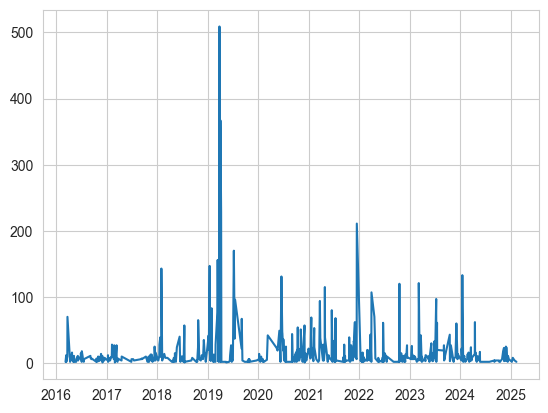

In [15]:
daily_rebellions = df[(df['Is_Rebellion'] == True) & (df['Party'] == 'Conservative')].groupby(df['Date'].dt.date).size().reset_index()
daily_rebellions.columns = ['date', 'rebellions']
plt.plot(daily_rebellions['date'], daily_rebellions['rebellions'])

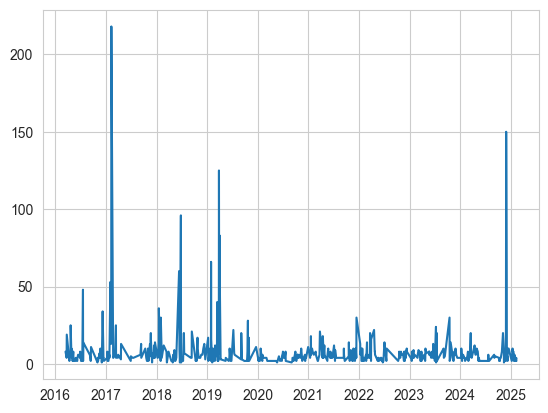

In [16]:
daily_rebellions = df[(df['Is_Rebellion'] == True) & (df['Party'] == 'Labour')].groupby(df['Date'].dt.date).size().reset_index()
daily_rebellions.columns = ['date', 'rebellions']
plt.plot(daily_rebellions['date'], daily_rebellions['rebellions'])

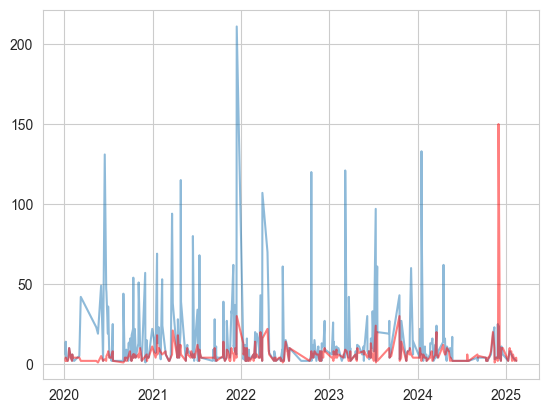

In [17]:
daily_rebellions = df[(df['Is_Rebellion'] == True) & (df['Party'] == 'Conservative') & (df['Division Date'] > "2020")].groupby(df['Date'].dt.date).size().reset_index()
daily_rebellions.columns = ['date', 'rebellions']
plt.plot(daily_rebellions['date'], daily_rebellions['rebellions'], alpha=0.5)
daily_rebellions = df[(df['Is_Rebellion'] == True) & (df['Party'] == 'Labour') & (df['Division Date'] > "2020")].groupby(df['Date'].dt.date).size().reset_index()
daily_rebellions.columns = ['date', 'rebellions']
plt.plot(daily_rebellions['date'], daily_rebellions['rebellions'], c='red' , alpha=0.5)

<Figure size 1500x800 with 0 Axes>

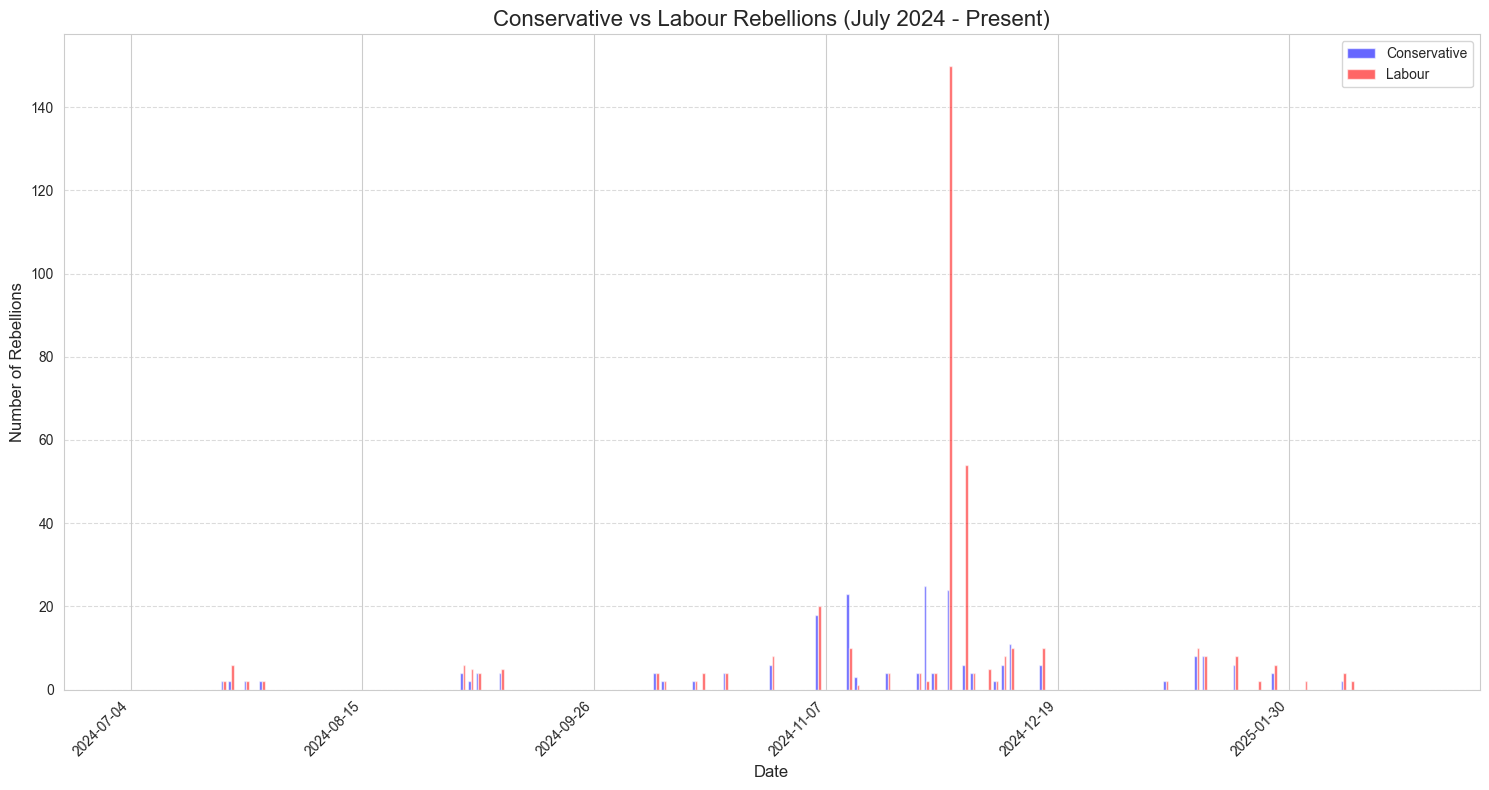

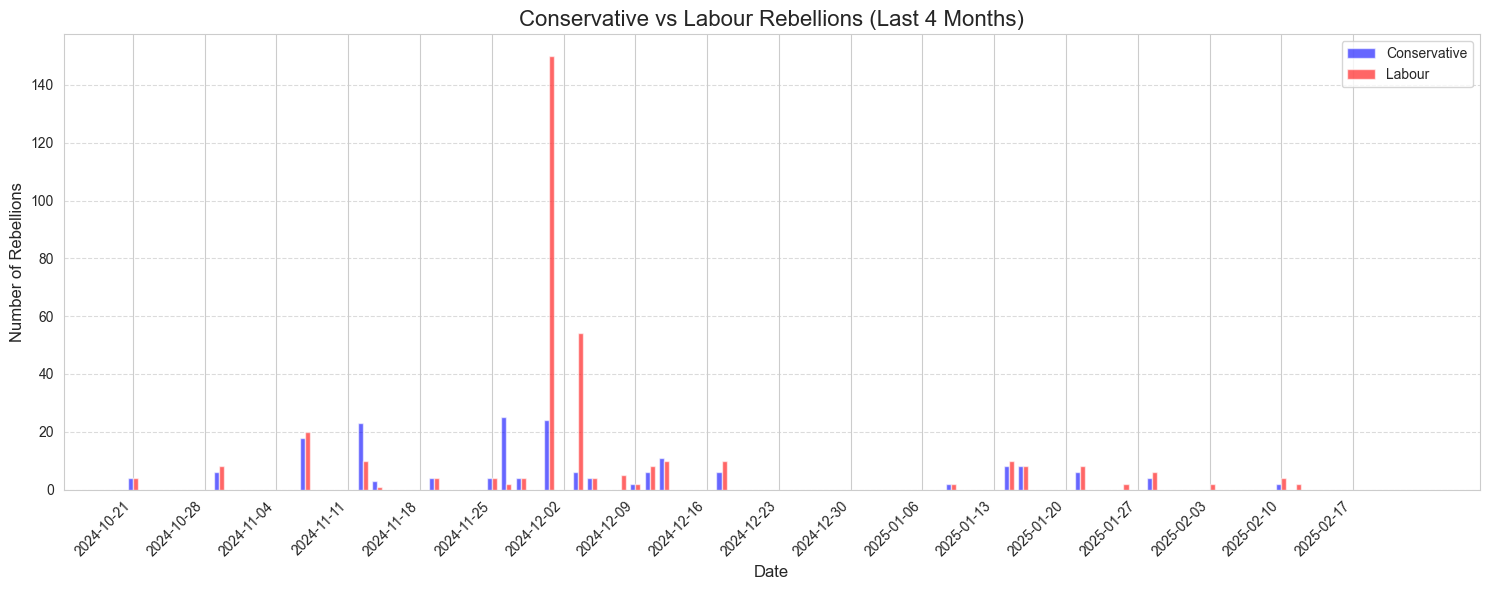

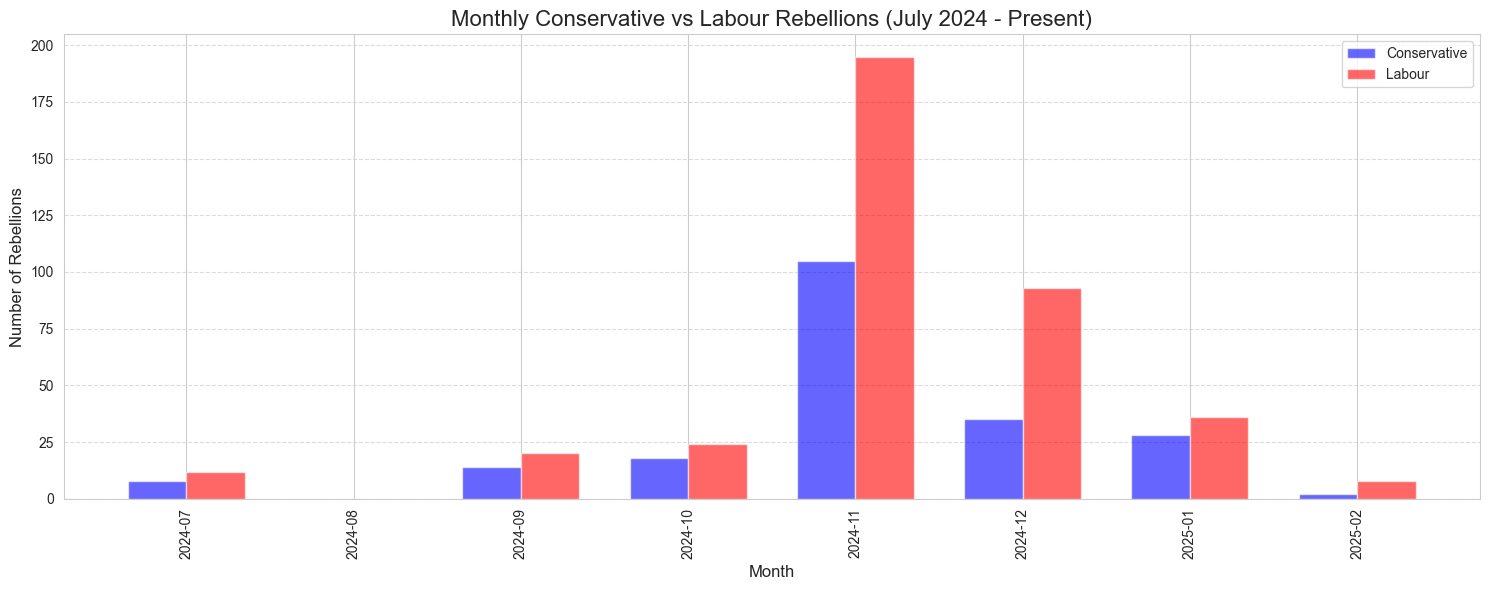

Total Conservative rebellions since July 2020: 210
Total Labour rebellions since July 2020: 388

Monthly averages:
Conservative monthly average: 26.25 rebellions
Labour monthly average: 48.50 rebellions

Most rebellious day for Conservatives: 2024-11-26 with 25 rebellions
Most rebellious day for Labour: 2024-11-29 with 150 rebellions


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Assuming df is your dataframe with all the vote data
# Create a date range from July 4, 2020 to today
start_date = pd.to_datetime('2024-07-04')
end_date = pd.to_datetime('2025-02-21')  # Using today's date
date_range = pd.date_range(start=start_date, end=end_date)

# Create a DataFrame with all dates
all_dates = pd.DataFrame({'date': date_range})
all_dates['date_only'] = all_dates['date'].dt.date

# Count Conservative rebellions by day
cons_rebellions = df[(df['Is_Rebellion'] == True) & 
                     (df['Party'] == 'Conservative') & 
                     (df['Date'] >= start_date)].copy()
cons_daily = cons_rebellions.groupby(cons_rebellions['Date'].dt.date).size().reset_index()
cons_daily.columns = ['date', 'con_rebellions']

# Count Labour rebellions by day
lab_rebellions = df[(df['Is_Rebellion'] == True) & 
                    (df['Party'] == 'Labour') & 
                    (df['Date'] >= start_date)].copy()
lab_daily = lab_rebellions.groupby(lab_rebellions['Date'].dt.date).size().reset_index()
lab_daily.columns = ['date', 'lab_rebellions']

# Merge with all_dates to include days with zero rebellions
all_dates_with_rebellions = all_dates.merge(cons_daily, left_on='date_only', right_on='date', how='left')
all_dates_with_rebellions = all_dates_with_rebellions.merge(lab_daily, left_on='date_only', right_on='date', how='left')

# Fill NaN values with 0
all_dates_with_rebellions['con_rebellions'] = all_dates_with_rebellions['con_rebellions'].fillna(0)
all_dates_with_rebellions['lab_rebellions'] = all_dates_with_rebellions['lab_rebellions'].fillna(0)

# Create a bar chart
plt.figure(figsize=(15, 8))

# Filter out weekends or non-sitting days (optional)
# If Parliament doesn't sit on weekends, we might want to exclude those days
is_weekday = all_dates_with_rebellions['date_x'].dt.dayofweek < 5  # 0-4 are Monday to Friday
sitting_days = all_dates_with_rebellions[is_weekday].copy()

# To create the dual bar chart, we need x positions
# For each date, we'll create two bars side by side
x = np.arange(len(sitting_days))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(15, 8))

# Create the bars
con_bars = ax.bar(x - width/2, sitting_days['con_rebellions'], width, color='blue', alpha=0.6, label='Conservative')
lab_bars = ax.bar(x + width/2, sitting_days['lab_rebellions'], width, color='red', alpha=0.6, label='Labour')

# Add labels and title
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Rebellions', fontsize=12)
ax.set_title('Conservative vs Labour Rebellions (July 2024 - Present)', fontsize=16)
ax.legend()

# Format x-axis with dates
# Since we have many dates, we'll show only every N days
show_every_n_days = 30  # Adjust this based on your preference
date_labels = sitting_days['date_x'].dt.strftime('%Y-%m-%d')
ax.set_xticks(x[::show_every_n_days])
ax.set_xticklabels(date_labels[::show_every_n_days], rotation=45, ha='right')

# Add a grid for easier reading
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Create a zoomed-in version for the last 3 months
last_4_months = pd.to_datetime('2025-02-21') - pd.DateOffset(months=4)
recent_data = sitting_days[sitting_days['date_x'] >= last_4_months].copy()

if len(recent_data) > 0:
    x_recent = np.arange(len(recent_data))
    
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    
    con_bars_recent = ax2.bar(x_recent - width/2, recent_data['con_rebellions'], width, color='blue', alpha=0.6, label='Conservative')
    lab_bars_recent = ax2.bar(x_recent + width/2, recent_data['lab_rebellions'], width, color='red', alpha=0.6, label='Labour')
    
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Number of Rebellions', fontsize=12)
    ax2.set_title('Conservative vs Labour Rebellions (Last 4 Months)', fontsize=16)
    ax2.legend()
    
    # For recent data, we can show more date labels
    date_labels_recent = recent_data['date_x'].dt.strftime('%Y-%m-%d')
    ax2.set_xticks(x_recent[::5])  # Show every 5th day
    ax2.set_xticklabels(date_labels_recent[::5], rotation=45, ha='right')
    
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

# Create monthly aggregates for a clearer view of trends
all_dates_with_rebellions['year_month'] = all_dates_with_rebellions['date_x'].dt.to_period('M')
monthly_rebellions = all_dates_with_rebellions.groupby('year_month').agg({
    'con_rebellions': 'sum',
    'lab_rebellions': 'sum'
}).reset_index()

# Convert period to datetime for plotting
monthly_rebellions['date'] = monthly_rebellions['year_month'].dt.to_timestamp()

# Create monthly bar chart
fig3, ax3 = plt.subplots(figsize=(15, 6))

x_monthly = np.arange(len(monthly_rebellions))
con_bars_monthly = ax3.bar(x_monthly - width/2, monthly_rebellions['con_rebellions'], width, color='blue', alpha=0.6, label='Conservative')
lab_bars_monthly = ax3.bar(x_monthly + width/2, monthly_rebellions['lab_rebellions'], width, color='red', alpha=0.6, label='Labour')

ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Number of Rebellions', fontsize=12)
ax3.set_title('Monthly Conservative vs Labour Rebellions (July 2024 - Present)', fontsize=16)
ax3.legend()

# Format x-axis with months
month_labels = monthly_rebellions['date'].dt.strftime('%Y-%m')
ax3.set_xticks(x_monthly)
ax3.set_xticklabels(month_labels, rotation=90)

ax3.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Print some summary statistics
print(f"Total Conservative rebellions since July 2020: {int(all_dates_with_rebellions['con_rebellions'].sum())}")
print(f"Total Labour rebellions since July 2020: {int(all_dates_with_rebellions['lab_rebellions'].sum())}")

# Calculate monthly averages
print("\nMonthly averages:")
print(f"Conservative monthly average: {monthly_rebellions['con_rebellions'].mean():.2f} rebellions")
print(f"Labour monthly average: {monthly_rebellions['lab_rebellions'].mean():.2f} rebellions")

# Find the most rebellious days
max_con_day = all_dates_with_rebellions.loc[all_dates_with_rebellions['con_rebellions'].idxmax()]
max_lab_day = all_dates_with_rebellions.loc[all_dates_with_rebellions['lab_rebellions'].idxmax()]

print(f"\nMost rebellious day for Conservatives: {max_con_day['date_x'].strftime('%Y-%m-%d')} with {int(max_con_day['con_rebellions'])} rebellions")
print(f"Most rebellious day for Labour: {max_lab_day['date_x'].strftime('%Y-%m-%d')} with {int(max_lab_day['lab_rebellions'])} rebellions")